In [4]:
from Solvers import adv_solver, span_solver, span_solver2
from Adversary import Adversary, Problem, to_str, visualize
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Examples import exact_k, threshold_k
from ElementDistinctness import ED
from copy import deepcopy as copy
import scipy
import cvxpy as cp
import itertools
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =200

In [5]:
class SpanProgram():
    def __init__(self, problem, I_dict, witnesses=None):
        self.witnesses = witnesses
        self.target = np.ones(problem.no_len)
        self.num_vects = np.sum([len(v) for i, v in I_dict.items()])
        self.ordered_I = [pair for pair in itertools.product(tuple(range(problem.n)), problem.alphabet)]
        self.I_to_mat = {}
        self.counter = 0
        self.vect_list = []
        self.ticks = []
        self.I_dict = I_dict
        self.problem = problem
        for pair, v_set in I_dict.items():
            self.ticks.append(self.counter)
            self.I_to_mat[pair] = list(range(self.counter, self.counter + len(v_set)))
            self.counter += len(v_set)
            for vect in v_set:
                self.vect_list.append(vect)
            # self.vect_list.append(*v_set)
        self.A = np.array(self.vect_list).T 
    
    def get_activated_A(self, x):
        activated_A = np.zeros(self.A.shape)
        for i in range(len(x)):
            interval = self.I_to_mat[(i, x[i])]
            activated_A[:, interval] = self.A[:, interval]
        return activated_A
        
    def apply(x, witness):
        return get_activated_A(x) @ witness
    
    def visualize_A(self):
        x_ticks = []
        for i in self.ordered_I:
            x_ticks.append(i)
            x_ticks += [''] * (len(self.I_dict[i])-1)
        visualize(self.A, (x_ticks, [to_str(no) for no in self.problem.no_instances]))
    
    def visualize_witnesses(self):
        y_ticks = []
        for i in self.ordered_I:
            y_ticks.append(i)
            y_ticks += [''] * (len(self.I_dict[i])-1)
        print(y_ticks)
        visualize(np.array(self.witnesses), ([ to_str(yes) for yes in self.problem.yes_instances], y_ticks))

In [6]:
def rand_function(n, alpha='01'):
    yes = []
    no = []
    for s in itertools.product(*[alpha]*n):
        if np.random.randint(2):
            yes.append(s)
        else:
            no.append(s)
    return Problem(no, yes)

In [7]:
prob = threshold_k(3, 2)
print(prob)
v, X = span_solver(prob, {'solver': 'SCS', 'verbose': True})

No:[(0, 0, 1), (0, 1, 0), (1, 0, 0)]
Yes:[(0, 1, 1), (1, 0, 1), (1, 1, 0)]
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 23 07:41:19 PM: Your problem has 325 variables, 15 constraints, and 0 parameters.
(CVXPY) Jul 23 07:41:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 23 07:41:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 23 07:41:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 23 07:41:19 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 23 07:41

15
{0.0, 1.0, 0.86602540378444, 0.5}


C:\Users\blake\AppData\Local\Temp/ipykernel_3008/4039430360.py:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  num_zeros = np.sum(v.shape[0] for v in vects)


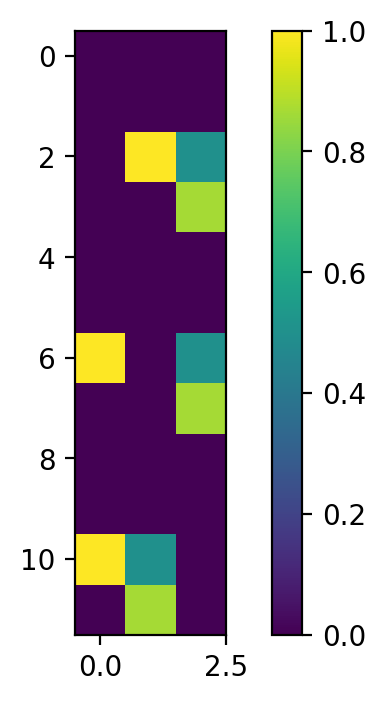

[(0, 0), '', (0, 1), '', (1, 0), '', (1, 1), '', (2, 0), '', (2, 1), '']
['001', '010', '100']
(3, 12)


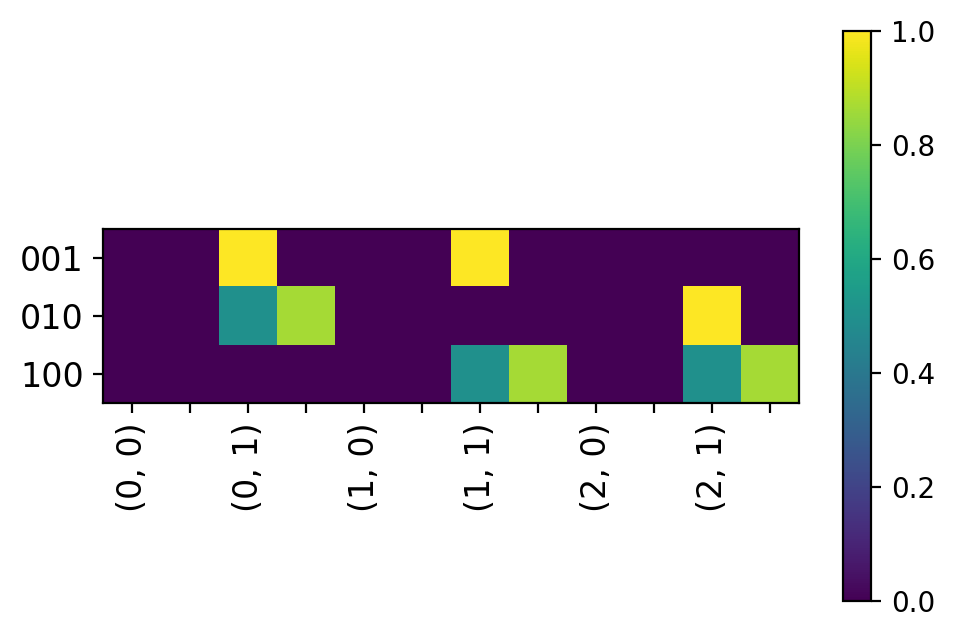

[(0, 0), '', (0, 1), '', (1, 0), '', (1, 1), '', (2, 0), '', (2, 1), '']
['011', '101', '110']
[(0, 0), '', (0, 1), '', (1, 0), '', (1, 1), '', (2, 0), '', (2, 1), '']
(3, 12)


ValueError: The number of FixedLocator locations (12), usually from a call to set_ticks, does not match the number of ticklabels (3).

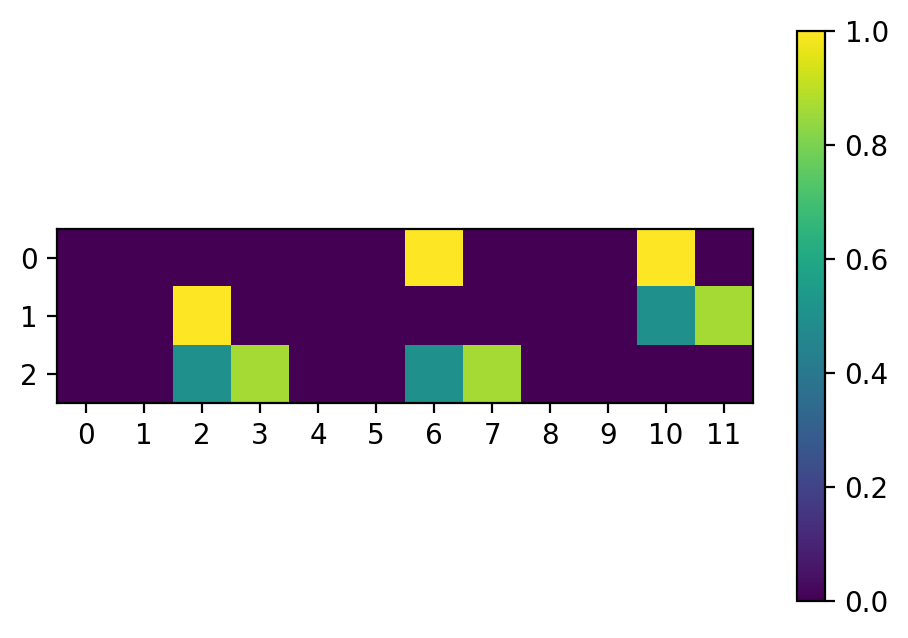

In [8]:
def get_cholesky_fact(A, eps_pow=15):
    for i in range(eps_pow,1,-1):
        print(i)
        try:
            curr_A = A + 10**-i * np.eye(A.shape[0])
            return np.round(scipy.linalg.cholesky(curr_A), i-1)
        except:
            pass
def decompose_cholesky(L, problem):
    # print(problem.no_len)
    partials = []
    for i in range(problem.n):
        full_partial = L[i * problem.len: (i+1)* problem.len, i * problem.len: (i+1)* problem.len]
        nonzero_columns = []
        for j in range(full_partial.shape[1]):
            v = full_partial[:, j]
            if np.linalg.norm(v) > 10**-6:
                # print('j', j)
                nonzero_columns.append(v)
        partials.append(np.array(nonzero_columns).T)
    return partials

def span_from_decomp(partials, problem):
    I = {}
    for j, b in itertools.product(range(problem.n), problem.alphabet):
        I[(j, b)] = []
        for i in range(partials[j].shape[1]):
            v = np.zeros(problem.no_len)
            for no_index in range(problem.no_len):
                no = problem.no_instances[no_index]
                if no[j] != b:
                    # print(j, i, no_index)
                    v[no_index] = partials[j][no_index, i]
            I[(j,b)].append(v)
    witnesses = []
    for yes_index in range(problem.yes_len):
        yes = problem.yes_instances[yes_index]
        w = []
        for (j, b), vects in I.items():
            if yes[j] != b:
                num_zeros = np.sum(v.shape[0] for v in vects)
                w += [0] * partials[j].shape[1]
            else:
                w += list(partials[j][problem.no_len + yes_index, :])
        # print(w)
        witnesses.append(np.array(w))
        
    return SpanProgram(problem, I, witnesses)
                
X2 = np.round(X, 4)
# print(X)
L = get_cholesky_fact(X2)
partials = decompose_cholesky(L.T, prob)
# print(partials[0].shape)
# plt.imshow(L.T)
# plt.show()
# print(sp.A)
# for partial in partials:
    # plt.imshow(partial)
    # plt.colorbar()
    # plt.show()
# plt.imshow()
sp = span_from_decomp(partials, prob)
# plt.imshow()
print(set(sp.A.flatten()))
plt.imshow(np.array(sp.witnesses).T)
plt.colorbar()
plt.show()
sp.visualize_A()
sp.visualize_witnesses()
print(np.array(sp.witnesses).T)
# plt.imshow(np.array(sp.witnesses) - sp.A)
# plt.colorbar()

In [2]:
print(np.array([1,2,3]).shape)

NameError: name 'np' is not defined

In [3]:
print(v, np.max([X[i][i] for i in range(X.shape[0])]))
print('norm', np.linalg.norm(X, 2))
print('len', X.shape[0])
print('rank', np.linalg.matrix_rank(X2), np.linalg.matrix_rank(X))
print(np.trace(X2))
evals, evects = np.linalg.eig(X2[:6, :6])
visualize(evects.real, [prob.yes_instances + prob.no_instances] * 2)

NameError: name 'v' is not defined

In [3]:
print('boop1')

boop1


In [7]:
input('bop')
def ez_space_vects(problem):
    vects = {}
    for j in range(problem.n):
        print('j', j)
        for b in problem.alphabet:
            vects[(j,b)] = []
            v = np.zeros(problem.no_len)
            for no_index in range(problem.no_len):
                no = problem.no_instances[no_index]
                if no[j] != b:
                    v[no_index] = 1
                    
            vects[(j,b)].append(v)
    return SpanProgram( problem, vects)
input('boop')
prob = threshold_k(3, 2)
print(prob)
sp = ez_space_vects(prob)
# sp.A[0][1] = -1

KeyboardInterrupt: Interrupted by user

In [ ]:
def find_opt_witness(span_program):
    A = span_program.A
    problem = span_program.problem
    witness_vars = [cp.Variable(A.shape[1]) for _ in range(span_program.problem.yes_len)]
    constraints = [span_program.get_activated_A(x) @ witness_vars[problem.yes_instance_to_index[x]] == np.ones(problem.no_len) for x in span_program.problem.yes_instances]
    for x in problem.yes_instances:
        w = witness_vars[problem.yes_instance_to_index[x]]
        for i in range(len(x)):       
            for b in problem.alphabet:
                if x[i] != b:
                    constraints += [w[j] == 0 for j in span_program.I_to_mat[(i, b)]]
    opt_func = cp.Minimize(cp.max(cp.vstack([cp.norm(w, 2) for w in witness_vars])))
    opt_prob = cp.Problem(opt_func, constraints)
    opt_prob.solve(solver='SCS', verbose=True)
    return opt_prob.value, np.array([w.value for w in witness_vars]).T

v, W = find_opt_witness(sp)
print(W)
print(sp.A)
sp.visualize_A()
sp.witnesses = W
sp.visualize_witnesses()

In [23]:
print(sp.A @W )

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1.

In [60]:

def special_span_sdp(problem, d):
    t = cp.Variable()
    vects = {z: [cp.Variable(d) for j in range(problem.n)] for z in problem.instances}
    constraints = []
    for yes, no in itertools.product(problem.yes_instances, problem.no_instances):
        constraints.append(cp.sum(
            [cp.scalar_product(vects[yes][j], vects[no][j]) for j in range(problem.n) if yes[j] != no[j]]) == 1
        )
    
    opt_func = cp.max(cp.vstack([
        cp.sum([vects[z][j]**2 for j in range(problem.n)])
        for z in problem.instances])
    )
    
    opt_prob = cp.Problem(cp.Minimize(opt_func), constraints)
    opt_prob.solve()
    return opt_prob.value, [[vects[z][j].value for z in problem.instances] for j in range(problem.n)]
    
def test_sdp():
    x = cp.Variable(10)
    y = cp.Variable(10)
    z = cp.Variable(10)
    w = cp.Variable(10)
    constraints = [x >= 2, y >= 3, w >= 4, z >= 5]
    opt_prob = cp.Problem(cp.Minimize(x @ y), constraints)
    opt_prob.solve()
    # return opt_prob.valuex.value, y.value
prob = threshold_k(3, 2)

In [61]:
val, P = special_span_sdp(prob, 3)
print(P)
# test_sdp()

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
-Sum(conj(var2386) @ var2374, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2386) @ var2374
-Sum(conj(var2387) @ var2378, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2387) @ var2378
-Sum(conj(var2385) @ var2370, None, False) + -Sum(conj(var2386) @ var2371, None, False) + -Sum(conj(var2387) @ var2372, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2385) @ var2370
|--  conj(var2386) @ var2371
|--  conj(var2387) @ var2372
-Sum(conj(var2379) @ var2373, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2379) @ var2373
-Sum(conj(var2379) @ var2376, None, False) + -Sum(conj(var2380) @ var2377, None, False) + -Sum(conj(var2381) @ var2378, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2379) @ var2376
|--  conj(var2380) @ var2377
|--  conj(var2381) @ var2378
-Sum(conj(var2381) @ var2372, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2381) @ var2372
-Sum(conj(var2382) @ var2373, None, False) + -Sum(conj(var2383) @ var2374, None, False) + -Sum(conj(var2384) @ var2375, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2382) @ var2373
|--  conj(var2383) @ var2374
|--  conj(var2384) @ var2375
-Sum(conj(var2382) @ var2376, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2382) @ var2376
-Sum(conj(var2383) @ var2371, None, False) == 1.0 , because the following subexpressions are not:
|--  conj(var2383) @ var2371